# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 2

Please use the following code to prepare the dataset.
 

In [3]:
from folktables.acs import adult_filter
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import pandas as pd

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person', root_dir="/mnt/storage/Datasets/folktables")
acs_data = data_source.get_data(states=["CA"], download=True)


def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)

# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)
        
features.head()

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,21,20.0,52,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,65,8.0,33,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,33,40.0,53,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,18,18.0,106,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,27,50.0,23,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
groups

,SEX,RAC1P
0,1,1
1,1,1
2,1,1
3,2,1
4,1,1
...,...,...
129558,1,1
129559,2,1
129560,1,1
129561,1,1


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(features, labels, groups, test_size=0.1, random_state=0)


In [12]:
#######
# YOUR CODE
#######
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
#groups
from sklearn.model_selection import cross_val_score

numeric_features = ["AGEP","WKHP", "PWGTP"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(X_train,y_train.values.ravel())

cv = KFold(n_splits=(100))
scores = cross_val_score(clf, X_test, y_test.values.ravel(), cv = cv)
print(scores)

[0.86153846 0.83076923 0.84615385 0.82307692 0.80769231 0.84615385
 0.77692308 0.79230769 0.8        0.82307692 0.8        0.77692308
 0.76153846 0.76153846 0.76923077 0.81538462 0.76153846 0.82307692
 0.80769231 0.83846154 0.80769231 0.86153846 0.76923077 0.77692308
 0.75384615 0.8        0.86153846 0.83846154 0.8        0.79230769
 0.76153846 0.82307692 0.82307692 0.76923077 0.77692308 0.80769231
 0.80769231 0.83846154 0.81538462 0.76923077 0.83076923 0.76153846
 0.8        0.81538462 0.84615385 0.73846154 0.74615385 0.89230769
 0.77692308 0.75384615 0.74615385 0.83076923 0.82307692 0.84615385
 0.80769231 0.81538462 0.8        0.81395349 0.79069767 0.82945736
 0.80620155 0.81395349 0.82945736 0.7751938  0.79069767 0.82945736
 0.75968992 0.81395349 0.7751938  0.81395349 0.72868217 0.82170543
 0.76744186 0.75193798 0.86821705 0.82170543 0.75193798 0.81395349
 0.82170543 0.78294574 0.79069767 0.79844961 0.86821705 0.78294574
 0.8372093  0.86046512 0.76744186 0.80620155 0.7751938  0.8217

<Axes: ylabel='Count'>

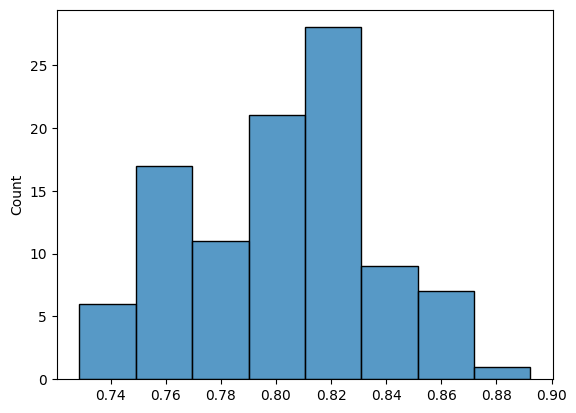

In [13]:
import seaborn as sns

sns.histplot(scores)

In [40]:
X_test.loc[groups_test[groups_test["SEX"] == 2].index.tolist()]

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
72476,63,50.0,99,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
25524,36,30.0,67,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
57955,32,40.0,66,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
119330,25,40.0,250,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
6278,54,45.0,90,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62379,48,40.0,61,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2967,21,30.0,99,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
57657,65,60.0,141,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
60385,27,40.0,67,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [ ]:
groups_test["SEX" == 1]

1
2


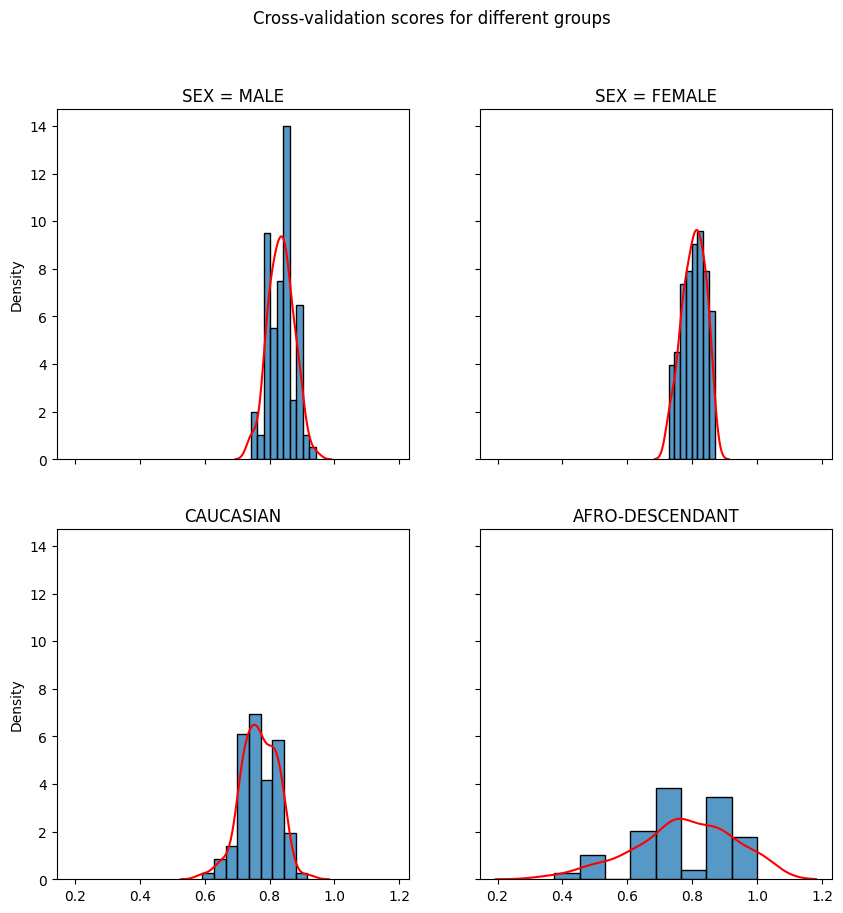

In [54]:
# score when split the dataset
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2,2, figsize=(10,10), sharey=True, sharex=True)

for i in range(1,3):
    print(i)
    score_sex = cross_val_score(clf, X_test.loc[groups_test[groups_test["SEX"] == i].index.tolist()], 
                                y_test.loc[groups_test[groups_test["SEX"] == i].index.tolist()].values.ravel(), 
                                cv = cv)
    score_race = cross_val_score(clf, X_test.loc[groups_test[groups_test["RAC1P"] == i].index.tolist()], 
                                y_test.loc[groups_test[groups_test["RAC1P"] == i].index.tolist()].values.ravel(), 
                                cv = cv)
    
    sns.histplot(score_sex, ax=ax[i-1, 0], kde=False, stat="density", line_kws={"color":"red"})
    sns.kdeplot(score_sex, ax=ax[i-1, 0], color="red")
    sns.histplot(score_race, ax=ax[i-1, 1], kde=False, stat="density", line_kws={"color":"red"})
    sns.kdeplot(score_race, ax=ax[i-1, 1], color="red")

ax[0,0].set_title("SEX = MALE")
ax[0,1].set_title("SEX = FEMALE")


ax[1,0].set_title("CAUCASIAN")
ax[1,1].set_title("AFRO-DESCENDANT")


plt.suptitle("Cross-validation scores for different groups")
plt.show()
